In [1]:
from __future__ import print_function
import glob
from itertools import chain
import os
import cv2
import random
import zipfile
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from functools import reduce
import torch.nn as nn
from einops import rearrange, repeat
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.transforms import ToPILImage
# from linformer import Linformer
from PIL import Image
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
# from vit_pytorch.efficient import ViT
# from model import BiSeNet
import torchvision.transforms as transforms
from skimage import io, img_as_float
import timm

In [2]:
#Import ViT Packages
from utils_ViT import load_pretrained_weights, as_tuple, resize_positional_embedding_
from configs import PRETRAINED_MODELS
from transformer import *

# Import 3DDFA Packages
# import yaml
# from FaceBoxes import FaceBoxes
# from TDDFA import TDDFA
# from utils.functions import draw_landmarks
# from utils.render import render
# from utils.depth import depth
# from utils.pncc import pncc
# from utils.uv import uv_tex
# from utils.pose import viz_pose


In [3]:
seed = 17
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [4]:
train_dir_real = '/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/full_train_set/real/'
train_dir_fake = '/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/full_train_set/fake/'


In [5]:
train_list_real = glob.glob(os.path.join(train_dir_real,'*'))
train_list_fake = glob.glob(os.path.join(train_dir_fake,'*'))

In [6]:
np.random.shuffle(train_list_real)
np.random.shuffle(train_list_fake)
np.random.shuffle(train_list_real)
np.random.shuffle(train_list_fake)
np.random.shuffle(train_list_real)
np.random.shuffle(train_list_fake)

In [7]:
train_list = []
train_list.extend(train_list_real[:30000])
train_list.extend(train_list_fake[:30000])
len(train_list)

60000

In [8]:
print(f"Train Data Real: {len(train_list_real)}")
print(f"Train Data Fake: {len(train_list_fake)}")
print(f"Total Train Data: {len(train_list)}")
print('***********************************')
print('***********************************')

Train Data Real: 103201
Train Data Fake: 162446
Total Train Data: 60000
***********************************
***********************************


In [9]:
np.random.shuffle(train_list)
np.random.shuffle(train_list)
np.random.shuffle(train_list)
np.random.shuffle(train_list)
np.random.shuffle(train_list)
np.random.shuffle(train_list)
np.random.shuffle(train_list)
np.random.shuffle(train_list)


In [10]:
labels = [path.split('\\')[-2].split('.')[0].split('/')[-1] for path in train_list]
print(labels[:10])

['fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake']


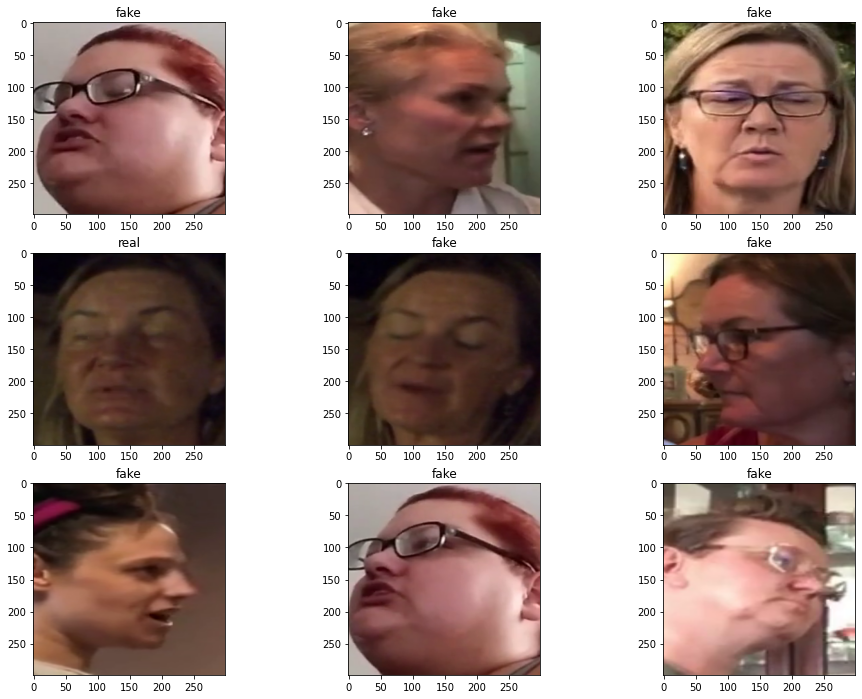

In [11]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [12]:
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
        iaa.Resize((224, 224)),
#         iaa.Crop(px=(0, 16)),
        iaa.Fliplr(0.5), # horizontally flip
        iaa.OneOf([
            iaa.Affine(scale=1.5),
            iaa.Affine(rotate=20),
            iaa.Affine(translate_px=(-20, 20)),
            iaa.Cutout(fill_mode="constant", cval=0, nb_iterations=1, size=0.3)
        ]),
#         iaa.OneOf([
#             iaa.JpegCompression(compression=(60, 70)),
#             iaa.GaussianBlur((0, 1.0)),
#             iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.3),
#             iaa.Multiply((0.5, 1.0), per_channel=0.2),
#             iaa.Cutout(fill_mode="constant", cval=0, nb_iterations=1, size=0.5)
#                 ])
        ], random_order=True)
      
    def __call__(self, img):
        img = np.array(img).astype(np.uint8)
        img = self.aug.augment_image(img)
        img = torchvision.transforms.ToTensor()(img)
        img = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)
        return img
transforms_imgaug = ImgAugTransform()

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
#         torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
#         torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [13]:
import cv2
import dlib
from imutils import face_utils
import imutils
import numpy as np
import torch

def face_remap(shape):
    remapped_image = cv2.convexHull(shape)
    return remapped_image

def augment_face(detector, predictor, img, random_num):
    frame = cv2.imread(img)
#     frame = img
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    out_face = np.zeros_like(frame)
    # out_face = frame
    faces = detector(gray, 1) 
    if not faces:
        pass
    else:
        for face in faces:
            landmarks = predictor(gray, face)
            shape = face_utils.shape_to_np(landmarks)
            remapped_shape = np.zeros_like(shape) 
            feature_mask = np.zeros((frame.shape[0], frame.shape[1]))

        #Lower face
        if random_num == 1:
            remapped_shape = face_remap(shape[1:12])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[3:14])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[6:17])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Eyes and Mouth
        if random_num == 2:
            remapped_shape = face_remap(shape[37:42])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[43:48])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[49:68])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Eyes, Mouth and Nose
        elif random_num == 3:
            remapped_shape = face_remap(shape[28:36])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[37:42])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[43:48])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[49:68])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Lower left side of face
        elif random_num == 4:
            remapped_shape = face_remap(shape[1:12])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Lower right side of face
        elif random_num == 5:
            remapped_shape = face_remap(shape[6:17])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Nose and Mouth
        elif random_num == 6:
            remapped_shape = face_remap(shape[28:36])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[49:68])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Mouth
        elif random_num == 7:
            remapped_shape = face_remap(shape[49:68])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        # Eyes and Nose
        elif random_num == 8:
            remapped_shape = face_remap(shape[37:42])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[43:48])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[28:46])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
        
        
        feature_mask = feature_mask.astype(np.bool)
        out_face[feature_mask] = frame[feature_mask]
        frame = frame - out_face
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         cv2.imwrite("out_face.png", frame)
    
    return frame

In [14]:
class DeepFakeSet(Dataset):
    def __init__(self, file_list, transform=None):

        self.file_list = file_list
        self.transform = transform
        self.to_img = ToPILImage()
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor("FaceExtraction/shape_predictor_81_face_landmarks.dat")

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        random_num = torch.randint(1, 10, (1,))
        augmented_face = augment_face(self.detector, self.predictor, img_path, random_num)
        img_transformed = self.transform(self.to_img(augmented_face))

        label = img_path.split('\\')[-2].split('.')[0].split('/')[-1]
        label = 1 if label == "real" else 0

        return img_transformed, label

In [15]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=173)

In [16]:
# train_data = DeepFakeSet(training_features, training_labels)
# valid_data = DeepFakeSet(validation_features, validation_labels)
# test_data = DeepFakeSet(test_list, transform=test_transforms)

train_data = DeepFakeSet(train_list, transform=transforms_imgaug)
valid_data = DeepFakeSet(valid_list, transform=val_transforms)
# test_data = DeepFakeSet(test_list, transform=test_transforms)

batch_size = 8

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
# # test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))

48000 6000
12000 1500


In [17]:
device = 'cuda'
# device = 'cpu'

C:\Users\Sohail\AppData\Local\Temp/ipykernel_16056/351711942.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  feature_mask = feature_mask.astype(np.bool)


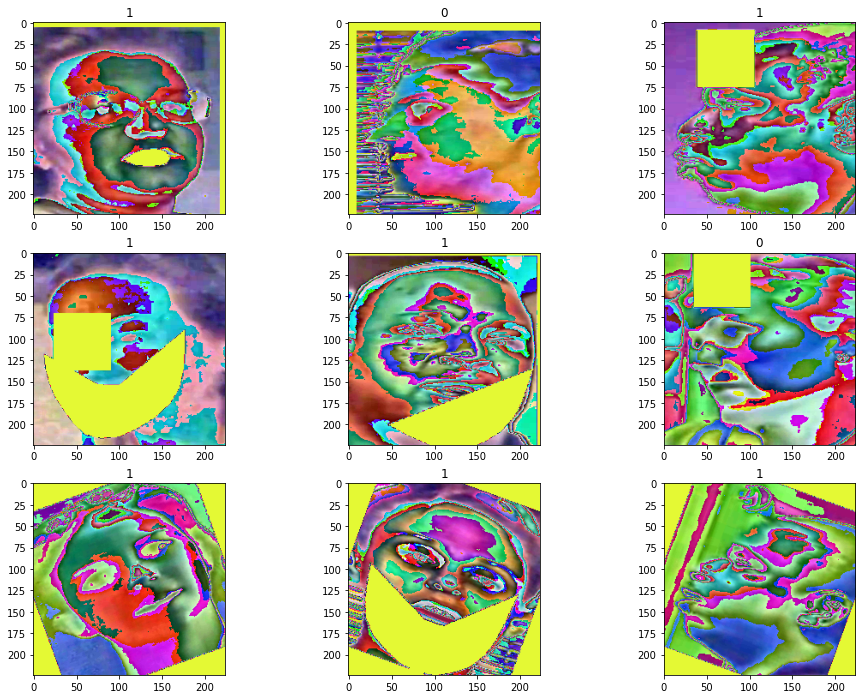

In [18]:
to_img = ToPILImage()

random_idx = np.random.randint(1, len(train_data), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = (to_img(train_data[idx][0]))
    ax.set_title(train_data[idx][1])
    ax.imshow(img)

In [19]:
"""model.py - Model and module class for ViT.
   They are built to mirror those in the official Jax implementation.
"""

from typing import Optional
import torch
from torch import nn
from torch.nn import functional as F


# from transformer import Transformer
# from utils_ViT import load_pretrained_weights, as_tuple
# from configs import PRETRAINED_MODELS

class Transformer(nn.Module):
    """Transformer with Self-Attentive Blocks"""
    def __init__(self, num_layers, dim, num_heads, ff_dim, dropout):
        super().__init__()
        self.blocks = nn.ModuleList([
            Block(dim, num_heads, ff_dim, dropout) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for block in self.blocks:
            x = block(x, mask)
        return x
    

class PositionalEmbedding1D(nn.Module):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def __init__(self, seq_len, dim):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, dim))
    
    def forward(self, x):
        """Input has shape `(batch_size, seq_len, emb_dim)`"""
        return x + self.pos_embedding
    
class SequenceEmbedding(nn.Module):
    """Adds (optionally learned) sequence embeddings to the inputs."""

    def __init__(self, seq_len, dim):
        super().__init__()
        self.seq_embedding = nn.Parameter(torch.zeros(1, 162, dim))
    
    def forward(self, x):
        """Input has shape `(batch_size, seq_len, emb_dim)`"""
        return x + self.seq_embedding


class ViT(nn.Module):
    """
    Args:
        name (str): Model name, e.g. 'B_16'
        pretrained (bool): Load pretrained weights
        in_channels (int): Number of channels in input data
        num_classes (int): Number of classes, default 1000

    References:
        [1] https://openreview.net/forum?id=YicbFdNTTy
    """

    def __init__(
        self, 
        name: Optional[str] = None, 
        pretrained: bool = False, 
        patches: int = 16,
        dim: int = 768,
        ff_dim: int = 3072,
        num_heads: int = 12,
        num_layers: int = 12,
        attention_dropout_rate: float = 0.0,
        dropout_rate: float = 0.1,
        representation_size: Optional[int] = None,
        load_repr_layer: bool = False,
        classifier: str = 'token',
        positional_embedding: str = '1d',
        in_channels: int = 3, 
        image_size: Optional[int] = None,
        num_classes: Optional[int] = None,
# from utils_ViT import load_pretrained_weights, as_tuple
# from configs import PRETRAINED_MODELS
    ):
        super().__init__()

        # Configuration
        if name is None:
            check_msg = 'must specify name of pretrained model'
            assert not pretrained, check_msg
            assert not resize_positional_embedding, check_msg
            if num_classes is None:
                num_classes = 1000
            if image_size is None:
                image_size = 384
        else:  # load pretrained model
            assert name in PRETRAINED_MODELS.keys(), \
                'name should be in: ' + ', '.join(PRETRAINED_MODELS.keys())
            config = PRETRAINED_MODELS[name]['config']
            patches = config['patches']
            dim = config['dim']
            ff_dim = config['ff_dim']
            num_heads = config['num_heads']
            num_layers = config['num_layers']
            attention_dropout_rate = config['attention_dropout_rate']
            dropout_rate = config['dropout_rate']
            representation_size = config['representation_size']
            classifier = config['classifier']
            if image_size is None:
                image_size = PRETRAINED_MODELS[name]['image_size']
            if num_classes is None:
                num_classes = PRETRAINED_MODELS[name]['num_classes']
        self.image_size = image_size                

        # Image and patch sizes
        h, w = as_tuple(image_size)  # image sizes
        fh, fw = as_tuple(patches)  # patch sizes
        gh, gw = h // fh, w // fw  # number of patches
        seq_len = gh * gw

        def get_feature_extractor():
            feature_extractor = timm.create_model('xception', features_only=True, pretrained=True)
            feature_extractor.eval()
            return feature_extractor
#         self.parse_net = ViT.load_face_parser()
        self.xception_feature_extractor = get_feature_extractor()
    
        def get_resnet():
            feature_extractor = timm.create_model('efficientnet_b4', features_only=True, pretrained=True)
#             feature_extractor.eval()
            return feature_extractor
#         self.parse_net = ViT.load_face_parser()
        self.resnet_feature_extractor = get_resnet()
    
        # Patch embedding
#         self.patch_embedding = nn.Conv2d(in_channels, dim, kernel_size=(14,28), stride=(14, 28))
        
#         self.sequence_embedding = SequenceEmbedding(162, dim)
        self.linear_1 = torch.nn.Linear(49, 162)
#         self.linear_2 = torch.nn.Linear(2048, 768)
        self.proj = nn.Conv2d(2048, 768, 1)
    
#         self.linear_2 = torch.nn.Linear(100, 162)
        self.proj_2 = nn.Conv2d(448, 768, 1)
                
#       Class token
        if classifier == 'token':
            self.class_token = nn.Parameter(torch.zeros(1, 1, dim))
            seq_len += 1
        
#       Positional embedding
        if positional_embedding.lower() == '1d':
            self.positional_embedding = PositionalEmbedding1D(seq_len, dim)
        else:
            raise NotImplementedError()
                    
        #Transformer
        self.transformer = Transformer(num_layers=num_layers, dim=dim, num_heads=num_heads, 
                                       ff_dim=ff_dim, dropout=dropout_rate)
        
        # Representation layer
        if representation_size and load_repr_layer:
            self.pre_logits = nn.Linear(dim, representation_size)
            pre_logits_size = representation_size
        else:
            pre_logits_size = dim

        # Classifier head
        self.norm = nn.LayerNorm(pre_logits_size, eps=1e-6)
        self.fc = nn.Linear(pre_logits_size, num_classes)

        # Initialize weights
        self.init_weights()
        
        # Load pretrained model
        if pretrained:
            pretrained_num_channels = 3
            pretrained_num_classes = PRETRAINED_MODELS[name]['num_classes']
            pretrained_image_size = PRETRAINED_MODELS[name]['image_size']
            load_pretrained_weights(
                self, name, 
                load_fc=(num_classes == pretrained_num_classes),
                load_repr_layer=load_repr_layer,
                resize_positional_embedding=(image_size != pretrained_image_size),
            )
            
        
    @torch.no_grad()
    def init_weights(self):
        def _init(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  # _trunc_normal(m.weight, std=0.02)  # from .initialization import _trunc_normal
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.normal_(m.bias, std=1e-6)  # nn.init.constant(m.bias, 0)
        self.apply(_init)
        nn.init.constant_(self.fc.weight, 0)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.normal_(self.positional_embedding.pos_embedding, std=0.02)  # _trunc_normal(self.positional_embedding.pos_embedding, std=0.02)
        nn.init.constant_(self.class_token, 0)

    def forward(self, x):
        """Breaks image into patches, applies transformer, applies MLP head.
        print(data.shape)
         Args:
            x (tensor): `b,c,fh,fw`
        """
        b, c, fh, fw = x.shape
#         x = DDFA.generate_uv_tex(x, self.xception_feature_extractor, self.sequence_embedding, self.linear_1, self.proj)

        x1 = self.xception_feature_extractor(x)
        x1 = x1[-1]
        x1 = self.proj(x1).flatten(2)
        x1 = self.linear_1(x1)
        x1 = x1.transpose(2,1)
#         x1 = self.sequence_embedding(x1)
#         print(x1.shape)
        
        x2 = self.resnet_feature_extractor(x)
        x2 = x2[-1]
        x2 = self.proj_2(x2).flatten(2)
        x2 = self.linear_1(x2)
        x2 = x2.transpose(2,1)
#         x2 = self.sequence_embedding(x2)
#         print(x2.shape)
        
        x = torch.cat((x1, x2), dim=1)
#         print(x.shape)
#         x = self.patch_embedding(x)  # b,d,gh,gw
#         print(x.shape)
#         x = x.flatten(2).transpose(1, 2)  # b,gh*gw,d
#         print(x.shape)
        if hasattr(self, 'class_token'):
            x = torch.cat((self.class_token.expand(b, -1, -1), x), dim=1)  # b,gh*gw+1,d
        if hasattr(self, 'positional_embedding'): 
            x = self.positional_embedding(x)  # b,gh*gw+1,d 

        x = self.transformer(x)  # b,gh*gw+1,d
        if hasattr(self, 'pre_logits'):
            x = self.pre_logits(x)
            x = torch.tanh(x)
        if hasattr(self, 'fc'):
            x = self.norm(x)[:, 0]  # b,d
            x = self.fc(x)  # b,num_classes
        return x


In [20]:
model = ViT('B_16_imagenet1k', pretrained=True,
    image_size = 300,
    num_classes = 2)

Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 325, 768])
Missing keys when loading pretrained weights: ['xception_feature_extractor.conv1.weight', 'xception_feature_extractor.bn1.weight', 'xception_feature_extractor.bn1.bias', 'xception_feature_extractor.bn1.running_mean', 'xception_feature_extractor.bn1.running_var', 'xception_feature_extractor.conv2.weight', 'xception_feature_extractor.bn2.weight', 'xception_feature_extractor.bn2.bias', 'xception_feature_extractor.bn2.running_mean', 'xception_feature_extractor.bn2.running_var', 'xception_feature_extractor.block1.skip.weight', 'xception_feature_extractor.block1.skipbn.weight', 'xception_feature_extractor.block1.skipbn.bias', 'xception_feature_extractor.block1.skipbn.running_mean', 'xception_feature_extractor.block1.skipbn.running_var', 'xception_feature_extractor.block1.rep.0.conv1.weight', 'xception_feature_extractor.block1.rep.0.pointwise.weight', 'xception_feature_extractor.block1.rep.1.weight', 'xc

In [40]:
# PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/no_seqemb_eval_img_aug_ensemble_vit_7epochs_fs_df_f2f_nt.pth")
# model.load_state_dict(torch.load(PATH))
# model.to(device)

In [41]:
epochs = 30
lr = 3e-3
# gamma = 0.7

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [45]:
# NO SegEmbed f2f only eval on with_new_train_valid_strategy
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        print(data.shape)
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(valid_loader):
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    
    if epoch == 1:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/facecutout_ensembled_dfdc_2epochs_60000images.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 2:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/facecutout_ensembled_dfdc_3epochs_60000images.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 3:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/facecutout_ensembled_dfdc_4epochs_60000images.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 4:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/facecutout_ensembled_dfdc_5epochs_60000images.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 5:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/facecutout_ensembled_dfdc_6epochs_60000images.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 6:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/facecutout_ensembled_dfdc_7epochs_60000images.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 7:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/facecutout_ensembled_dfdc_8epochs_60000images.pth")
        torch.save(model.state_dict(), PATH)
        
        
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/8000 [00:00<?, ?it/s]

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [27]:
# # NO SegEmbed f2f only eval on with_new_train_valid_strategy
# for epoch in range(epochs):
#     epoch_loss = 0
#     epoch_accuracy = 0
#     for data, label in tqdm(train_loader):
#         data = data.to(device)
#         label = label.to(device)
#         output = model(data)
#         loss = criterion(output, label)
# #         print("HERE")
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         acc = (output.argmax(dim=1) == label).float().mean()
#         epoch_accuracy += acc / len(train_loader)
#         epoch_loss += loss / len(train_loader)

#     with torch.no_grad():
#         epoch_val_accuracy = 0
#         epoch_val_loss = 0
#         for data, label in tqdm(valid_loader):
#             data = data.to(device)
#             label = label.to(device)
# #             print(data.shape)aa
#             val_output = model(data)
#             val_loss = criterion(val_output, label)

#             acc = (val_output.argmax(dim=1) == label).float().mean()
#             epoch_val_accuracy += acc / len(valid_loader)
#             epoch_val_loss += val_loss / len(valid_loader)
    
#     if epoch == 1:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/ensembled_dfdc_2epochs_60000images.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 2:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/ensembled_dfdc_3epochs_60000images.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 3:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/ensembled_dfdc_4epochs_60000images.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 4:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/ensembled_dfdc_5epochs_60000images.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 5:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/ensembled_dfdc_6epochs_60000images.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 6:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/ensembled_dfdc_7epochs_60000images.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 7:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/ensembled_dfdc_8epochs_60000images.pth")
#         torch.save(model.state_dict(), PATH)
        
        
#     print(
#         f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
#     )

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.5530 - acc: 0.7048 - val_loss : 0.3911 - val_acc: 0.8232



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.3468 - acc: 0.8451 - val_loss : 0.2858 - val_acc: 0.8723



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.2601 - acc: 0.8869 - val_loss : 0.1973 - val_acc: 0.9150



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.2113 - acc: 0.9090 - val_loss : 0.1744 - val_acc: 0.9281



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.1802 - acc: 0.9240 - val_loss : 0.1431 - val_acc: 0.9394



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.1554 - acc: 0.9342 - val_loss : 0.1362 - val_acc: 0.9419



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.1405 - acc: 0.9420 - val_loss : 0.1096 - val_acc: 0.9553



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.1285 - acc: 0.9476 - val_loss : 0.1076 - val_acc: 0.9579



  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.1185 - acc: 0.9511 - val_loss : 0.1041 - val_acc: 0.9592



  0%|          | 0/8000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
# # NO SegEmbed f2f only eval on with_new_train_valid_strategy
# for epoch in range(epochs):
#     epoch_loss = 0
#     epoch_accuracy = 0
#     for data, label in tqdm(train_loader):
#         data = data.to(device)
#         label = label.to(device)
#         output = model(data)
#         loss = criterion(output, label)
# #         print("HERE")
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         acc = (output.argmax(dim=1) == label).float().mean()
#         epoch_accuracy += acc / len(train_loader)
#         epoch_loss += loss / len(train_loader)

#     with torch.no_grad():
#         epoch_val_accuracy = 0
#         epoch_val_loss = 0
#         for data, label in tqdm(valid_loader):
#             data = data.to(device)
#             label = label.to(device)
# #             print(data.shape)aa
#             val_output = model(data)
#             val_loss = criterion(val_output, label)

#             acc = (val_output.argmax(dim=1) == label).float().mean()
#             epoch_val_accuracy += acc / len(valid_loader)
#             epoch_val_loss += val_loss / len(valid_loader)
    
#     if epoch == 1:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/ensembled_dfdc_2epochs.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 2:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/ensembled_dfdc_3epochs.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 3:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/ensembled_dfdc_4epochs.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 4:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/ensembled_dfdc_5epochs.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 5:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/ensembled_dfdc_6epochs.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 6:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/ensembled_dfdc_7epochs.pth")
#         torch.save(model.state_dict(), PATH)
#     elif epoch == 7:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/ensembled_dfdc_8epochs.pth")
#         torch.save(model.state_dict(), PATH)
        
        
#     print(
#         f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
#     )

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.5560 - acc: 0.6940 - val_loss : 0.3580 - val_acc: 0.8439



  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.2854 - acc: 0.8742 - val_loss : 0.1882 - val_acc: 0.9220



  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.1911 - acc: 0.9191 - val_loss : 0.1440 - val_acc: 0.9414



  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.1510 - acc: 0.9381 - val_loss : 0.1019 - val_acc: 0.9600



  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.1273 - acc: 0.9475 - val_loss : 0.0987 - val_acc: 0.9625



  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.1115 - acc: 0.9551 - val_loss : 0.0860 - val_acc: 0.9656



  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0975 - acc: 0.9620 - val_loss : 0.0824 - val_acc: 0.9679



  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0906 - acc: 0.9638 - val_loss : 0.0645 - val_acc: 0.9747



  0%|          | 0/16000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
# NO SegEmbed f2f only eval on with_new_train_valid_strategy
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(valid_loader):
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    
    if epoch == 1:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/new_ensemble_vit_2epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 2:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/new_ensemble_vit_3epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 3:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/new_ensemble_vit_4epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 4:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/new_ensemble_vit_5epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 5:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/new_ensemble_vit_6epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 6:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/new_ensemble_vit_7epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 7:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/new_ensemble_vit_8epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
        
        
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2439 - acc: 0.8759 - val_loss : 0.2858 - val_acc: 0.9086



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0425 - acc: 0.9838 - val_loss : 0.3279 - val_acc: 0.9281



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0195 - acc: 0.9926 - val_loss : 0.3545 - val_acc: 0.9271



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0122 - acc: 0.9955 - val_loss : 0.4203 - val_acc: 0.9213



  0%|          | 0/33334 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# NO SegEmbed f2f only eval on with_new_train_valid_strategy
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(valid_loader):
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    
#     if epoch == 0:
#         PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/1epochs_f2f.pth")
#         torch.save(model.state_dict(), PATH)
    if epoch == 1:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/2epochs_df.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 2:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/3epochs_df.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 3:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/4epochs_df.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 4:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/5epochs_df.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 5:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/6epochs_df.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 6:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/7epochs_df.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 7:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/8epochs_df.pth")
        torch.save(model.state_dict(), PATH)
        
        
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/1667 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.7141 - acc: 0.5156 - val_loss : 0.6781 - val_acc: 0.5783



  0%|          | 0/1667 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.4897 - acc: 0.7409 - val_loss : 0.2704 - val_acc: 0.8912



  0%|          | 0/1667 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.2585 - acc: 0.8954 - val_loss : 0.1718 - val_acc: 0.9276



  0%|          | 0/1667 [00:00<?, ?it/s]

In [23]:
# NO SegEmbed f2f only eval on with_new_train_valid_strategy
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(valid_loader):
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    
    if epoch == 0:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/no_seqemb_eval_img_aug_ensemble_vit_1epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 1:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/no_seqemb_eval_img_aug_ensemble_vit_2epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 2:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/no_seqemb_eval_img_aug_ensemble_vit_3epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 3:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/no_seqemb_eval_img_aug_ensemble_vit_4epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 4:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/no_seqemb_eval_img_aug_ensemble_vit_5epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 5:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/no_seqemb_eval_img_aug_ensemble_vit_6epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 6:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/no_seqemb_eval_img_aug_ensemble_vit_7epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 7:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/no_seqemb_eval_img_aug_ensemble_vit_8epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
        
        
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.3732 - acc: 0.8108 - val_loss : 0.2246 - val_acc: 0.9127



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1681 - acc: 0.9302 - val_loss : 0.2313 - val_acc: 0.9208



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.1197 - acc: 0.9515 - val_loss : 0.1789 - val_acc: 0.9383



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0928 - acc: 0.9626 - val_loss : 0.2002 - val_acc: 0.9429



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0775 - acc: 0.9682 - val_loss : 0.2205 - val_acc: 0.9404



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0666 - acc: 0.9732 - val_loss : 0.2072 - val_acc: 0.9373



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0589 - acc: 0.9762 - val_loss : 0.2528 - val_acc: 0.9255



  0%|          | 0/33334 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
# NO SegEmbed f2f only eval on with_new_train_valid_strategy
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(valid_loader):
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    
    if epoch == 0:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/eval_no_momentum_img_aug_ensemble_vit_1epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 1:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/eval_no_momentum_img_aug_ensemble_vit_2epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 2:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/eval_no_momentum_img_aug_ensemble_vit_3epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 3:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/eval_no_momentum_img_aug_ensemble_vit_4epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 4:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/eval_no_momentum_img_aug_ensemble_vit_5epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 5:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/eval_no_momentum_img_aug_ensemble_vit_6epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 6:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/eval_no_momentum_img_aug_ensemble_vit_7epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 7:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/eval_no_momentum_img_aug_ensemble_vit_8epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
        
        
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.4217 - acc: 0.7805 - val_loss : 0.3823 - val_acc: 0.8602



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1879 - acc: 0.9220 - val_loss : 0.2758 - val_acc: 0.8990



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.1364 - acc: 0.9446 - val_loss : 0.2110 - val_acc: 0.9294



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.1100 - acc: 0.9545 - val_loss : 0.2780 - val_acc: 0.9188



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0913 - acc: 0.9624 - val_loss : 0.3006 - val_acc: 0.9199



  0%|          | 0/33334 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
# NO SegEmbed f2f only eval on with_new_train_valid_strategy   tf_efficientnet_b5_ns
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(valid_loader):
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    
    if epoch == 1:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/img_aug_ensemble_vit_2epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 2:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/img_aug_ensemble_vit_3epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 3:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/img_aug_ensemble_vit_4epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 4:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/img_aug_ensemble_vit_5epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 5:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/img_aug_ensemble_vit_6epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 6:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/img_aug_ensemble_vit_7epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 7:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/img_aug_ensemble_vit_8epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
        
        
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2928 - acc: 0.8619 - val_loss : 0.1796 - val_acc: 0.9358



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1340 - acc: 0.9460 - val_loss : 0.2167 - val_acc: 0.9185



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0976 - acc: 0.9600 - val_loss : 0.2017 - val_acc: 0.9367



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0777 - acc: 0.9692 - val_loss : 0.1636 - val_acc: 0.9521



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0648 - acc: 0.9739 - val_loss : 0.2310 - val_acc: 0.9432



  0%|          | 0/33334 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
# NO SegEmbed f2f only eval on with_new_train_valid_strategy
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(valid_loader):
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    
    if epoch == 1:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/ensemble_vit_2epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 2:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/ensemble_vit_3epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 3:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/ensemble_vit_4epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 4:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/ensemble_vit_5epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 5:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/ensemble_vit_6epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 6:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/ensemble_vit_7epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 7:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/ensemble_vit_8epochs_fs_df_f2f_nt.pth")
        torch.save(model.state_dict(), PATH)
        
        
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2470 - acc: 0.8808 - val_loss : 0.2320 - val_acc: 0.9146



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0669 - acc: 0.9738 - val_loss : 0.2989 - val_acc: 0.9254



  0%|          | 0/33334 [00:00<?, ?it/s]

  0%|          | 0/6667 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0378 - acc: 0.9850 - val_loss : 0.3379 - val_acc: 0.9201



  0%|          | 0/33334 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
# NO SegEmbed f2f only eval on with_new_train_valid_strategy
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(valid_loader):
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    
    if epoch == 1:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/no_cutout_UVtex_face_2epochs_fs_df.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 2:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/no_cutout_UVtex_face_3epochs_fs_df.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 3:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/no_cutout_UVtex_face_4epochs_fs_df.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 4:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/no_cutout_UVtex_face_5epochs_fs_df.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 5:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/no_cutout_UVtex_face_6epochs_fs_df.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 6:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/no_cutout_UVtex_face_7epochs_fs_df.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 7:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/no_cutout_UVtex_face_8epochs_fs_df.pth")
        torch.save(model.state_dict(), PATH)
        
        
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/13334 [00:00<?, ?it/s]

  0%|          | 0/2667 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.4800 - acc: 0.7214 - val_loss : 0.2123 - val_acc: 0.9193



  0%|          | 0/13334 [00:00<?, ?it/s]

  0%|          | 0/2667 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.0888 - acc: 0.9658 - val_loss : 0.1191 - val_acc: 0.9647



  0%|          | 0/13334 [00:00<?, ?it/s]

  0%|          | 0/2667 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.0497 - acc: 0.9795 - val_loss : 0.1338 - val_acc: 0.9670



  0%|          | 0/13334 [00:00<?, ?it/s]

  0%|          | 0/2667 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.0355 - acc: 0.9846 - val_loss : 0.1037 - val_acc: 0.9726



  0%|          | 0/13334 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
# NO SegEmbed f2f only eval on with_new_train_valid_strategy
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(valid_loader):
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    
    if epoch == 1:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/UVtex_face_2epochs.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 2:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/UVtex_face_3epochs.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 3:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/UVtex_face_4epochs.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 4:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/UVtex_face_5epochs.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 5:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/UVtex_face_6epochs.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 6:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/UVtex_face_7epochs.pth")
        torch.save(model.state_dict(), PATH)
    elif epoch == 7:
        PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code/UVtex_face_8epochs.pth")
        torch.save(model.state_dict(), PATH)
        
        
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.4350 - acc: 0.7436 - val_loss : 0.0764 - val_acc: 0.9780



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1196 - acc: 0.9540 - val_loss : 0.0494 - val_acc: 0.9852



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0830 - acc: 0.9668 - val_loss : 0.0419 - val_acc: 0.9863



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0683 - acc: 0.9717 - val_loss : 0.0434 - val_acc: 0.9867



  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# NO SegEmbed f2f only eval on with_new_train_valid_strategy
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    
    if epoch == 2:    
        torch.save(model, '/home/sohailkhan/Desktop/ddfa_trained_models/dfdc_model_finetune_uv_tex_image_f2f_3_epochs')
            
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


Epoch : 1 - loss : 0.0868 - acc: 0.9695 - val_loss : 0.1017 - val_acc: 0.9706



In [ ]:
# With SegEmbed f2f only eval on with_new_train_valid_strategy
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    
    if epoch == 2:    
        torch.save(model, '/home/sohailkhan/Desktop/ddfa_trained_models/uv_tex_image_f2f_3_epochs')
    elif epoch == 4:    
        torch.save(model, '/home/sohailkhan/Desktop/ddfa_trained_models/uv_tex_image_f2f_5_epochs')
    elif epoch == 6:    
        torch.save(model, '/home/sohailkhan/Desktop/ddfa_trained_models/uv_tex_image_f2f_7_epochs')
    elif epoch == 9:    
        torch.save(model, '/home/sohailkhan/Desktop/ddfa_trained_models/uv_tex_image_f2f_10_epochs')
    elif epoch == 12:    
        torch.save(model, '/home/sohailkhan/Desktop/ddfa_trained_models/uv_tex_image_f2f_13_epochs')
    elif epoch == 14:    
        torch.save(model, '/home/sohailkhan/Desktop/ddfa_trained_models/uv_tex_image_f2f_15_epochs')
            
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [ ]:
# With SegEmbed NT_F2F Sets
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
            
    if epoch == 4:    
        torch.save(model, '/home/sohailkhan/Desktop/ddfa_trained_models/uv_tex_image_WITH_nt_f2f_ViT_300k_images_5_epochs')
    elif epoch == 6:    
        torch.save(model, '/home/sohailkhan/Desktop/ddfa_trained_models/uv_tex_image_WITH_nt_f2f_ViT_300k_images_7_epochs')
    elif epoch == 9:    
        torch.save(model, '/home/sohailkhan/Desktop/ddfa_trained_models/uv_tex_image_WITH_nt_f2f_ViT_300k_images_10_epochs')
    elif epoch == 12:    
        torch.save(model, '/home/sohailkhan/Desktop/ddfa_trained_models/uv_tex_image_WITH_nt_f2f_ViT_300k_images_13_epochs')
    elif epoch == 14:    
        torch.save(model, '/home/sohailkhan/Desktop/ddfa_trained_models/uv_tex_image_WITH_nt_f2f_ViT_300k_images_15_epochs')

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


Epoch : 1 - loss : 0.7017 - acc: 0.5007 - val_loss : 0.6940 - val_acc: 0.5037




Epoch : 2 - loss : 0.6949 - acc: 0.5002 - val_loss : 0.6944 - val_acc: 0.4981




Epoch : 3 - loss : 0.6942 - acc: 0.5018 - val_loss : 0.6960 - val_acc: 0.5003




Epoch : 4 - loss : 0.6774 - acc: 0.5479 - val_loss : 0.5594 - val_acc: 0.7174




Epoch : 5 - loss : 0.3375 - acc: 0.8495 - val_loss : 0.2138 - val_acc: 0.9152




Epoch : 6 - loss : 0.1190 - acc: 0.9561 - val_loss : 0.1956 - val_acc: 0.9276



In [21]:
# Without SegEmbed NT_F2F Sets
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
            
    if epoch == 4:    
        torch.save(model, '/home/sohailkhan/Desktop/ddfa_trained_models/uv_tex_image_WITH_nt_f2f_ViT_300k_images_5_epochs')
    elif epoch == 6:    
        torch.save(model, '/home/sohailkhan/Desktop/ddfa_trained_models/uv_tex_image_WITH_nt_f2f_ViT_300k_images_7_epochs')
    elif epoch == 9:    
        torch.save(model, '/home/sohailkhan/Desktop/ddfa_trained_models/uv_tex_image_WITH_nt_f2f_ViT_300k_images_10_epochs')
    elif epoch == 12:    
        torch.save(model, '/home/sohailkhan/Desktop/ddfa_trained_models/uv_tex_image_WITH_nt_f2f_ViT_300k_images_13_epochs')
    elif epoch == 14:    
        torch.save(model, '/home/sohailkhan/Desktop/ddfa_trained_models/uv_tex_image_WITH_nt_f2f_ViT_300k_images_15_epochs')

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


Epoch : 1 - loss : 0.7045 - acc: 0.4980 - val_loss : 0.6936 - val_acc: 0.4986




Epoch : 2 - loss : 0.6953 - acc: 0.4991 - val_loss : 0.6969 - val_acc: 0.4999



KeyboardInterrupt: 

In [ ]:
torch.save(model, 'segembed_trained_32000_images_ddfa.pt')

In [ ]:
# Without SegEmbed
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [ ]:
# With SegEmbed
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [ ]:
for data, label in train_loader:
    data.to(device)
    model(data)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aacd mb
            val_output = model(data)
            val_loss = criterion(val_output, label)
            
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
#         print("HERE")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

# Evaluate ViT

In [21]:
PATH = '/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/ensembled_dfdc_6epochs_3wrong.pth'
# PATH = '/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/lessaugprobability_facecutout_ensembled_ff_5epochs_200000images.pth'
device = 'cuda'
model.load_state_dict(torch.load(PATH), strict=True)
model.to(device)
model.eval()


ViT(
  (xception_feature_extractor): FeatureHookNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [22]:
# PATH = '/Users/Sohail/Desktop/FINAL_TIMM_hybrid_uv_tex_image_FS_DF_3_epochs'
# device = 'cuda'
# model = torch.load(PATH)
# model.to(device)
# model.eval()


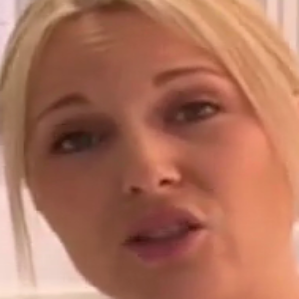

In [115]:
img = Image.open('/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/real/Video_Frames/RealTestSet/880/880_9.png')
img

In [116]:
tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), 
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
img = tfms(img)

In [117]:
labels_map = ["fake", "real"]
# Preprocess image

# Classify

probs = {}
with torch.no_grad():
    outputs = model(img.unsqueeze(0).to(device))
print('-----')
for idx in torch.topk(outputs[0], k=2).indices.tolist():
    prob = torch.softmax(outputs[0], 0)[idx].item()
    probs[idx] = (labels_map[idx], prob*100)
    print((labels_map[idx], prob*100))
#     print('[{idx}] {label:<75} ({p:.2f}%)'.format(idx=idx, label=labels_map[idx], p=prob*100))

-----
('real', 99.99991655349731)
('fake', 8.334985750479973e-05)


# Test ViT On FaceForensics++

In [22]:
videos = sorted(glob.glob('/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/real/Video_Frames/RealTestSet/*/'))
len(videos)

140

In [28]:
## Real FF++

model.eval()
labels_map = ["fake", "real"]
count = 0
predictions = {}
probs = {}
for vid in videos:
    count+=1
    print(count)
    fake_prob = 0
    real_prob = 0
    images = sorted(glob.glob('/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/real/Video_Frames/RealTestSet/'+str(vid.split('\\')[-2])+'/*.png'))
    if len(images) >= 4:
        for image in images:
            img = Image.open(image)
            tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      ])
            img = tfms(img)
            with torch.no_grad():
                outputs = model(img.unsqueeze(0).to(device))
            for idx in torch.topk(outputs[0], k=1).indices.tolist():
                prob = torch.softmax(outputs[0], 0)[idx].item()
                if labels_map[idx] == 'fake':
                    fake_prob += prob
                    real_prob += 1-prob
                else:
                    real_prob += prob
                    fake_prob += 1 - prob
        if real_prob > fake_prob:
            predictions[vid.split('/')[-2]] = 1
            probs[vid.split('/')[-2]] = (real_prob/len(images))
#             print(image)
#             print('real', real_prob/len(images))
        else:
            predictions[vid.split('/')[-2]] = 0
            probs[vid.split('/')[-2]] = 1-(fake_prob/len(images))
            print(image)
            print('fake', fake_prob/len(images))
    else:
        pass
    print('--------------')


1
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/real/Video_Frames/RealTestSet/000\000_915.png
fake 0.9562478289008141
--------------
2
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/real/Video_Frames/RealTestSet/003\003_915.png
fake 0.9890863560140133
--------------
3
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/real/Video_Frames/RealTestSet/012\012_915.png
fake 0.9551615379750729
--------------
4
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/real/Video_Frames/RealTestSet/015\015_915.png
fake 0.699987106025219
--------------
5
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/real/Video_Frames/RealTestSet/024\024_915.png
fake 0.9992254339158535
--------------
6
--------------
7
/Users/Sohail/Desktop/Research/PhD/Ye

KeyboardInterrupt: 

In [29]:
## Fake FF++

# model.eval()
# labels_map = ["fake", "real"]
# count = 0
# predictions = {}
# probs = {}
# for vid in videos:
#     count+=1
#     print(count)
#     fake_prob = 0
#     real_prob = 0
#     images = sorted(glob.glob('/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/fake/Video_Frames/FakeTestSet/NeuralTextures/'+str(vid.split('\\')[-1].split('.')[0])+'/*.png'))
#     if len(images) >= 4:
#         for image in images:
#             img = Image.open(image)
#             tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
#                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
#                                       ])
#             img = tfms(img)
#             with torch.no_grad():
#                 outputs = model(img.unsqueeze(0).to(device))
#             for idx in torch.topk(outputs[0], k=1).indices.tolist():
#                 prob = torch.softmax(outputs[0], 0)[idx].item()
#                 if labels_map[idx] == 'fake':
#                     fake_prob += prob
#                     real_prob += 1-prob
#                 else:
#                     real_prob += prob
#                     fake_prob += 1 - prob
#         if real_prob > fake_prob:
#             predictions[vid.split('/')[-2]] = 1
#             probs[vid.split('/')[-2]] = (real_prob/len(images))
#             print(image)
#             print('real', real_prob/len(images))
#         else:
#             predictions[vid.split('/')[-2]] = 0
#             probs[vid.split('/')[-2]] = 1-(fake_prob/len(images))
# #             print(image)
# #             print('fake', fake_prob/len(images))
#     else:
#         pass
#     print('--------------')


1
--------------
2
--------------
3
--------------
4
--------------
5
--------------
6
--------------
7
--------------
8
--------------
9
--------------
10
--------------
11
--------------
12
--------------
13
--------------
14
--------------
15
--------------
16
--------------
17
--------------
18
--------------
19
--------------
20
--------------
21
--------------
22
--------------
23
--------------
24
--------------
25
--------------
26
--------------
27
--------------
28
--------------
29
--------------
30
--------------
31
--------------
32
--------------
33
--------------
34
--------------
35
--------------
36
--------------
37
--------------
38
--------------
39
--------------
40
--------------
41
--------------
42
--------------
43
--------------
44
--------------
45
--------------
46
--------------
47
--------------
48
--------------
49
--------------
50
--------------
51
--------------
52
--------------
53
--------------
54
--------------
55
--------------
56
--------------
5

In [36]:
vid.split('\\')[-2]

'995'

# Test ViT On DFDC

In [26]:
videos = sorted(glob.glob('/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/test_set/real/*/'))
len(videos)

200

In [27]:
model.eval()
labels_map = ["fake", "real"]
count = 0
predictions = {}
probs = {}
for vid in videos:
    count+=1
    print(count)
    fake_prob = 0
    real_prob = 0
    images = sorted(glob.glob('/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/test_set/real/'+str(vid.split('/')[-1].split('\\')[-2])+'/*.png'))
    if len(images) >= 12:
        for image in images:
            img = Image.open(image)
            tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      ])
            img = tfms(img)
            with torch.no_grad():
                outputs = model(img.unsqueeze(0).to(device))
            for idx in torch.topk(outputs[0], k=1).indices.tolist():
                prob = torch.softmax(outputs[0], 0)[idx].item()
                if labels_map[idx] == 'fake':
                    fake_prob += prob
                    real_prob += 1-prob
                else:
                    real_prob += prob
                    fake_prob += 1 - prob
        if real_prob > fake_prob:
            predictions[vid.split('/')[-2]] = 1
            probs[vid.split('/')[-2]] = (real_prob/len(images))
#             print(image)
#             print('real', real_prob/len(images))
        else:
            predictions[vid.split('/')[-2]] = 0
            probs[vid.split('/')[-2]] = 1-(fake_prob/len(images))
            print(image)
            print('fake', fake_prob/len(images))
    else:
        pass
    print('--------------')

1
--------------
2
--------------
3
--------------
4
--------------
5
--------------
6
--------------
7
--------------
8
--------------
9
--------------
10
--------------
11
--------------
12
--------------
13
--------------
14
--------------
15
--------------
16
--------------
17
--------------
18
--------------
19
--------------
20
--------------
21
--------------
22
--------------
23
--------------
24
--------------
25
--------------
26
--------------
27
--------------
28
--------------
29
--------------
30
--------------
31
--------------
32
--------------
33
--------------
34
--------------
35
--------------
36
--------------
37
--------------
38
--------------
39
--------------
40
--------------
41
--------------
42
--------------
43
--------------
44
--------------
45
--------------
46
--------------
47
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/test_set/real/fopjiyxiqd\fopjiyxiqd_915.png
fake 0.7460558675229549
--------------
48

In [28]:
392/399

0.9824561403508771

In [161]:
import csv
# from itertools import izip

with open('/home/sohailkhan/Desktop/Sohail/Results/dfd_image.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(zip(fake_probs, real_probs))


In [17]:
fake_probs

[0.9996938241852654]

In [29]:
341/350

0.9742857142857143

In [23]:
labels_map = ["fake", "real"]

fake_prob = 0
real_prob = 0
images = sorted(glob.glob('/home/sohailkhan/Desktop/Sohail/ViT_test_images/dfdc/real/bnuwxhfahw/*.png'))
if len(images) >= 4:
    for image in images:
        img = Image.open(image)
        tfms = transforms.Compose([transforms.Resize((299,299)), transforms.ToTensor()])
        img = tfms(img)
        with torch.no_grad():
            outputs = model(img.unsqueeze(0).to(device))
        for idx in torch.topk(outputs[0], k=1).indices.tolist():
            prob = torch.softmax(outputs[0], 0)[idx].item()
            if labels_map[idx] == 'fake':
                fake_prob += prob
                real_prob += 1-prob
            else:
                real_prob += prob
                fake_prob += 1 - prob
    if real_prob > fake_prob:
        print('real')
        print(real_prob/len(images))
    else:
        print("fake")
        print(fake_prob/len(images))
else:
    pass
print('--------------')

real
0.9447830745152065
--------------


In [ ]:
real_prob/226

In [ ]:
fake_prob/226

# Visualize

In [90]:
new_model = torch.nn.Sequential(*list(model.children())[8:])
new_model.to(device)
outputs = new_model(img.unsqueeze(0).to(device))

In [107]:
out = outputs[-1]

In [112]:
sequence_embedding = SequenceEmbedding(162, 768)
#self.linear_2 = torch.nn.Linear(2048, 768)
out = nn.Conv2d(2048, 768, 1).to(device)(outputs[-1]).flatten(2)
out = torch.nn.Linear(100, 162).to(device)(out)
out = out.transpose(2,1)
out.shape

torch.Size([1, 162, 768])

In [113]:
sequence_embedding = SequenceEmbedding(162, 768)
#self.linear_2 = torch.nn.Linear(2048, 768)
out2 = nn.Conv2d(2048, 768, 1).to(device)(outputs[-1]).flatten(2)
out2 = torch.nn.Linear(100, 162).to(device)(out2)
out2 = out2.transpose(2,1)
out2.shape

torch.Size([1, 162, 768])

In [115]:
concated = torch.cat((out, out2), dim=1)

In [116]:
concated.shape

torch.Size([1, 324, 768])

<function matplotlib.pyplot.show(close=None, block=None)>

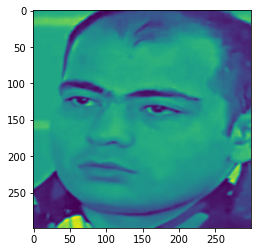

In [142]:
plt.imshow(img[2].cpu().detach().numpy())
plt.show

In [89]:
torch.nn.Sequential(*list(model.children())[8:])

Sequential(
  (0): FeatureHookNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplac

In [60]:
model

ViT(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (sequence_embedding): SequenceEmbedding()
  (linear_1): Linear(in_features=100, out_features=162, bias=True)
  (proj): Conv2d(2048, 768, kernel_size=(1, 1), stride=(1, 1))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_v): Linear(in_features=768, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_featu

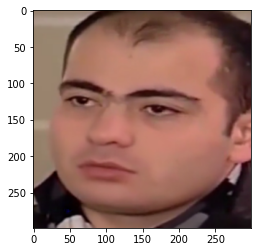

In [39]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(img.permute(1, 2, 0))

In [228]:
torch.nn.Sequential(*list(model.children())[8:]).children()[:-1]

TypeError: 'generator' object is not subscriptable

In [143]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import  DataLoader
from torchvision import models

import torchvision.transforms as transforms
import torchvision.datasets as dataset

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [232]:
no_of_layers=0
conv_layers=[]

model_children=list(new_model[0].children())

for child in model_children:
    if type(child)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(child)
    elif type(child)==nn.Sequential:
        print('here')
        for layer in child.children():
            if type(layer)==nn.Conv2d:
                no_of_layers+=1
                conv_layers.append(layer)
print(conv_layers)

[Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False), Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)]


In [187]:
results = [conv_layers[0](img.unsqueeze(0).to(device))]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results
print(outputs[0].shape)
outputs = outputs[0].cpu().detach().numpy()

torch.Size([1, 32, 149, 149])


In [222]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[0][:, :, :]
    layer_viz = layer_viz.data
#     print("Layer ",num_layer+1)
#     for i, filter in enumerate(layer_viz):
#         if i == 16: 
#             break
#         plt.subplot(2, 8, i + 1)
#         plt.imshow(filterr, cmap='gray')
#         plt.axis("off")
#     plt.show()
#     plt.close()

<Figure size 3600x720 with 0 Axes>

In [24]:
m = timm.create_model('xception', pretrained=True, num_classes=0)


In [26]:
parameters = filter(lambda p: p.requires_grad, model.parameters())
parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
print('Trainable Parameters: %.3fM' % parameters)

Trainable Parameters: 124.784M


In [2]:
import dlib

In [3]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('FaceExtraction/shape_predictor_68_face_landmarks.dat')

In [30]:
img = dlib.load_rgb_image('FaceExtraction/1.png')

rect = detector(img)[0]
sp = predictor(img, rect)
landmarks = np.array([[p.x, p.y] for p in sp.parts()])

In [20]:
# from imutils import face_utils
# import imutils
# import numpy as np
# import collections
# import dlib
# import cv2

# def face_remap(shape):
#     remapped_image = cv2.convexHull(shape)
#     return remapped_image

# """
# MAIN CODE STARTS HERE
# """
# # load the input image, resize it, and convert it to grayscale
# image = cv2.imread("FaceExtraction/2.png")
# image = imutils.resize(image, width=224)
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# out_face = np.zeros_like(image)

# # initialize dlib's face detector (HOG-based) and then create the facial landmark predictor
# detector = dlib.get_frontal_face_detector()
# predictor = predictor

# # detect faces in the grayscale image
# rects = detector(gray, 1)

# # loop over the face detections
# for (i, rect) in enumerate(rects):
#     """
#     Determine the facial landmarks for the face region, then convert the facial landmark (x, y)-coordinates to a NumPy array
#     """
#     shape = predictor(gray, rect)
#     shape = face_utils.shape_to_np(shape)

#    #initialize mask array
#     remapped_shape = np.zeros_like(shape) 
#     feature_mask = np.zeros((image.shape[0], image.shape[1]))   

#     # we extract the face
#     remapped_shape = face_remap(shape)
#     cv2.fillConvexPoly(feature_mask, remapped_shape[0:27], 1)
#     feature_mask = feature_mask.astype(np.bool)
#     out_face[feature_mask] = image[feature_mask]
# #     cv2.imshow("mask_inv", out_face)
#     cv2.imwrite("out_face.png", out_face)

In [32]:
# from imutils import face_utils
# import imutils
# import numpy as np
# import collections
# import dlib
# import cv2

# def face_remap(shape):
#     remapped_image = cv2.convexHull(shape)
#     return remapped_image

# """
# MAIN CODE STARTS HERE
# """
# # load the input image, resize it, and convert it to grayscale
# image = cv2.imread("FaceExtraction/2.png")
# image = imutils.resize(image, width=224)
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# predictor = dlib.shape_predictor('FaceExtraction/shape_predictor_68_face_landmarks.dat')
# out_face = np.zeros_like(image)

# # initialize dlib's face detector (HOG-based) and then create the facial landmark predictor
# detector = dlib.get_frontal_face_detector()
# predictor = predictor

# # detect faces in the grayscale image
# rects = detector(gray, 1)

# # loop over the face detections
# for (i, rect) in enumerate(rects):
#     """
#     Determine the facial landmarks for the face region, then convert the facial landmark (x, y)-coordinates to a NumPy array
#     """
#     shape = predictor(gray, rect)
#     shape = face_utils.shape_to_np(shape)

#    #initialize mask array
#     remapped_shape = np.zeros_like(shape) 
#     feature_mask = np.zeros((image.shape[0], image.shape[1]))   

#     # we extract the face
#     remapped_shape = face_remap(shape)
#     cv2.fillConvexPoly(feature_mask, shape[1:27], 2)
#     feature_mask = feature_mask.astype(np.bool)
#     out_face[feature_mask] = image[feature_mask]
    
    
# #     cv2.imshow("mask_inv", out_face)
#     cv2.imwrite("out_face.png", out_face)

C:\Users\Sohail\AppData\Local\Temp/ipykernel_30156/2594632823.py:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  feature_mask = feature_mask.astype(np.bool)


In [47]:
# import cv2
# import mediapipe as mp
# mp_drawing = mp.solutions.drawing_utils
# mp_drawing_styles = mp.solutions.drawing_styles
# mp_face_mesh = mp.solutions.face_mesh
# # import dlib
# import cv2
# import os
# import re
# import json
# import glob
# import numpy as np
# import random

# import torch



# # For static images:

# # IMAGE_FILES = ['FaceExtraction/2.png']
# IMAGE_FILES = sorted(glob.glob("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/video_mesh/real_face_frames/*.png"))
# drawing_spec = mp_drawing.DrawingSpec(thickness=0.5, circle_radius=1)
# with mp_face_mesh.FaceMesh(
#     static_image_mode=False,
#     max_num_faces=1,
#     refine_landmarks=True,
#     min_detection_confidence=0.5) as face_mesh:
#     for idx, file in enumerate(IMAGE_FILES):
#         black = torch.zeros([299, 299, 3])
#         black = black.cpu().detach().numpy()
#         image = cv2.imread(file)
#         # Convert the BGR image to RGB before processing.
#         results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

#         # Print and draw face mesh landmarks on the image.
#         if not results.multi_face_landmarks:
#             continue
# #         annotated_image = image.copy()
#         annotated_image = black
#         for face_landmarks in results.multi_face_landmarks:
# #             print('face_landmarks:', face_landmarks)
#             mp_drawing.draw_landmarks(
#               image=annotated_image,
#               landmark_list=face_landmarks,
#               connections=mp_face_mesh.FACEMESH_TESSELATION,
#               landmark_drawing_spec=None,
#               connection_drawing_spec=mp_drawing_styles
#               .get_default_face_mesh_tesselation_style())
# #             mp_drawing.draw_landmarks(
# #               image=annotated_image,
# #               landmark_list=face_landmarks,
# #               connections=mp_face_mesh.FACEMESH_CONTOURS,
# #               landmark_drawing_spec=None,
# #               connection_drawing_spec=mp_drawing_styles
# #               .get_default_face_mesh_contours_style())
# #             mp_drawing.draw_landmarks(
# #               image=annotated_image,
# #               landmark_list=face_landmarks,
# #               connections=mp_face_mesh.FACEMESH_IRISES,
# #               landmark_drawing_spec=None,
# #               connection_drawing_spec=mp_drawing_styles
# #               .get_default_face_mesh_iris_connections_style())
#         cv2.imwrite('video_mesh/real_meshes/annotated_image' + str(idx) + '.png', annotated_image)

In [30]:
PATH = ("/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Code_ICMR_Workshop_Paper/weights/ensembled_dfdc_after9epochs_60000images.pth")
torch.save(model.state_dict(), PATH)